In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import IPython.display as display
import time
import imageio

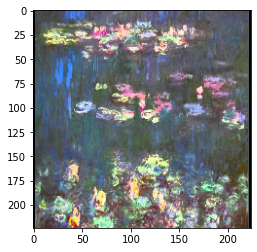

In [11]:
#style_path = tf.keras.utils.get_file('style.jpg', 'http://bit.ly/2mGfZIq')
style_path='/content/monet.jpg'
style_image = plt.imread(style_path)
style_image = cv2.resize(style_image, dsize=(224, 224))
style_image = style_image / 255.0
plt.imshow(style_image)
plt.show()

In [0]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet') # 마지막레이어 제외
# tf.keras.utils.plot_model(vgg)
# for layer in vgg.layers:
     # print(layer.name)


In [0]:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

vgg.trainable = False
outputs = [vgg.get_layer(name).output for name in style_layers]
model = tf.keras.Model([vgg.input], outputs)

In [0]:
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

In [0]:
style_batch = style_image.astype('float32')
style_batch = tf.expand_dims(style_batch, axis=0)
style_output = model(tf.keras.applications.vgg19.preprocess_input(style_batch * 255.0))

In [0]:
def get_outputs(image):
    image_batch = tf.expand_dims(image, axis=0)
    output = model(preprocess_input(image_batch * 255.0))
    outputs = [gram_matrix(out) for out in output]
    return outputs
  
def get_loss(outputs, style_outputs):
    return tf.reduce_sum([tf.reduce_mean((o-s)**2) for o,s in zip(outputs, style_outputs)])
  
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def high_pass_x_y(image):
    x_var = image[:,1:,:] - image[:,:-1,:]
    y_var = image[1:,:,:] - image[:-1,:,:]
    return x_var, y_var

def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

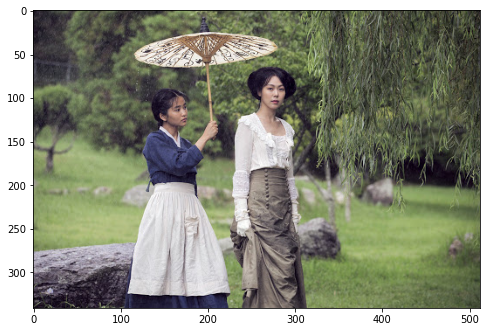

In [10]:
#content_path = tf.keras.utils.get_file('content.jpg', 'http://bit.ly/2mAfUX1')
content_path='/content/the_handmaid.jpg''
content_image=plt.imread(content_path)

max_dim=512
long_dim=max(content_image.shape[:-1])
scale=max_dim/long_dim
new_height=int(content_image.shape[0]*scale)
new_width=int(content_image.shape[1]*scale)

content_image=cv2.resize(content_image,dsize=(new_width,new_height));
content_image=content_image/255.0

plt.figure(figsize=(8,8))
plt.imshow(content_image)
plt.show()

In [6]:
content_batch = content_image.astype('float32')
content_batch = tf.expand_dims(content_batch, axis=0)

content_layers = ['block5_conv2']

vgg.trainable = False
outputs = [vgg.get_layer(name).output for name in content_layers]
model_content = tf.keras.Model([vgg.input], outputs)
content_output = model_content(preprocess_input(content_batch * 255.0))

/content


In [0]:
def get_content_output(image):
    image_batch = tf.expand_dims(image, axis=0)
    output = model_content(preprocess_input(image_batch * 255.0))
    return output

def get_content_loss(image, content_output):
    return tf.reduce_sum(tf.reduce_mean(image-content_output)**2)

In [0]:
opt = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.99, epsilon=1e-1)

total_variation_weight = 1e9
style_weight = 1e-2
content_weight = 1e4

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = get_outputs(image)
        output2 = get_content_output(image)
        loss = style_weight * get_loss(outputs, style_outputs)
        loss += content_weight * get_content_loss(output2, content_output)
        loss += total_variation_weight * total_variation_loss(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [0]:
start = time.time()

image = tf.Variable(content_image.astype('float32'))

epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    if n % 5 == 0 or n == epochs - 1:
        imageio.imwrite('style_{0}_content_{1}_transfer_epoch_{2}.png'.format(style_weight, content_weight, n), image.read_value().numpy())
    display.clear_output(wait=True)
    plt.figure(figsize=(8,8))
    plt.imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))